# Librairies

In [197]:
## Obtenir keypoints

import argparse

import numpy as np

import imageio

import torch

from tqdm import tqdm

import scipy
import scipy.io
import scipy.misc

from lib.model_test import D2Net
from lib.utils import preprocess_image
from lib.pyramid import process_multiscale

## Realiser matching

import cv2

import matplotlib.pyplot as plt

#import numpy as np

import os

from PIL import Image
import random

from skimage.feature import match_descriptors
from skimage.measure import ransac
from skimage.transform import ProjectiveTransform
from skimage.transform import AffineTransform

# Obtenir les keypoints pour toutes les fragments et fresques

1623 1546 417
 echelle 1.0  -  1.0
 echelle 1.0  -  1.0
Number of raw matches: 87.
Number of inliers: 6.
 echelle 1.0  -  1.0
Number of raw matches: 99.
Number of inliers: 39.
 echelle 1.0  -  1.0
Number of raw matches: 87.
Number of inliers: 6.
 echelle 1.0  -  1.0
Number of raw matches: 85.
Number of inliers: 7.
[[ 8.92234011e-01  1.94254298e+01 -3.10294066e+03]
 [ 1.73816229e+00  1.44097007e+01 -2.49056679e+03]
 [ 6.16783679e-03  7.32079761e-02 -1.20760623e+01]]
Transltation : ( -3102.9406571678296 , -2490.566793099871 )
Rotation :  -62.82764931387103


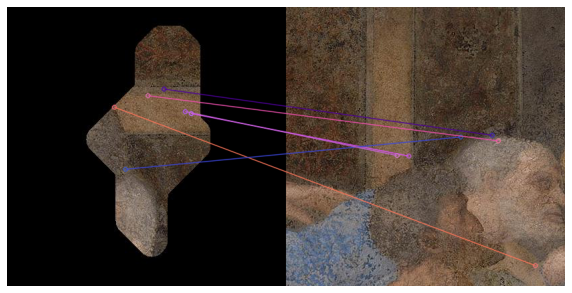

In [257]:

# Parameters
max_edge = 1600
max_sum_edges = 2800
model_file = 'models/d2_tf.pth'
multiscale = False
output_extension='.d2-net'
output_type='npz'
preprocessing='caffe'
use_relu=True
image_list_file='fresques/Leonardo-da-Vinci_Ultima-Cena_5193x2926/Leonardo-da-Vinci_Ultima-Cena_5193x2926_2019-2-28_13.56.32/fragments2.txt'
path_images = 'fresques/Leonardo-da-Vinci_Ultima-Cena_5193x2926/Leonardo-da-Vinci_Ultima-Cena_5193x2926_2019-2-28_13.56.32/frag_eroded'
path_keypoints = 'fresques/Leonardo-da-Vinci_Ultima-Cena_5193x2926/Leonardo-da-Vinci_Ultima-Cena_5193x2926_2019-2-28_13.56.32/keypoints/kpts_frag_'
path_imageOriginal = 'fresques/Leonardo-da-Vinci_Ultima-Cena_5193x2926/Leonardo-da-Vinci_Ultima-Cena_5193x2926.ppm'
path_imageOriginal_jpg = 'fresques/Leonardo-da-Vinci_Ultima-Cena_5193x2926/Leonardo-da-Vinci_Ultima-Cena_5193x2926.jpg'

# CUDA
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

# Creating CNN model
model = D2Net(
    model_file = model_file,
    use_relu = use_relu,
    use_cuda = use_cuda
)

# Functions
def crop_image(img,xC,yC,sizeX,sizeY):
    y,x,z = img.shape
    startx = xC - sizeX//2
    starty = yC - sizeY//2    
    return img[starty:(starty+sizeY),startx:(startx+sizeX),:]

def filteringBlackAreaKeypoints(img,keypoints, descriptors):
    new_descriptors = np.ones((1,descriptors.shape[1]))
    new_keypoints = [[1,1,1]]
    
#     print('img.shape', img.shape)
    
#     print('keypoints : ',keypoints)

    for i in range(len(keypoints)):
        kpt_x = int(keypoints[i][0])
        kpt_y = int(keypoints[i][1])
        img_kpt = img[(kpt_y-2):(kpt_y+3),(kpt_x-2):(kpt_x+3),:]
        
        nbr_zeros=0
        
        for m in range(img_kpt.shape[0]):
            for n in range(img_kpt.shape[1]):
                if(img_kpt[m,n,0]==0):
                    nbr_zeros += 1
                if(img_kpt[m,n,1]==0):
                    nbr_zeros += 1
                if(img_kpt[m,n,2]==0):
                    nbr_zeros += 1
                                
#         sum_masque = np.sum(img_kpt)
#         print('sum : ',sum_masque)
#         if(sum_masque >  2000):
#         print('nbr_zeros :',nbr_zeros)
        if (nbr_zeros<5):
#             plt.figure(figsize=(10, 10))
#             plt.imshow(img_kpt)
#             plt.axis('off')
#             plt.show()
#             print(img_kpt)
            new_keypoints = np.concatenate((new_keypoints,[keypoints[i]]),axis=0)
            new_descriptors = np.concatenate((new_descriptors,[descriptors[i]]),axis=0)
        
#     print('new_keypoints[1:] : ',new_keypoints[1:])
            
    return new_keypoints[1:], new_descriptors[1:]

def Detection_keypoints(image,max_edge,max_sum_edges,preprocessing,multiscale):
    
    if len(image.shape) == 2:
        image = image[:, :, np.newaxis]
        image = np.repeat(image, 3, -1)

    # TODO: switch to PIL.Image due to deprecation of scipy.misc.imresize.
    resized_image = image
    if max(resized_image.shape) > max_edge:
        resized_image = scipy.misc.imresize(
            resized_image,
            max_edge / max(resized_image.shape)
        ).astype('float')
    if sum(resized_image.shape[: 2]) > max_sum_edges:
        resized_image = scipy.misc.imresize(
            resized_image,
            max_sum_edges / sum(resized_image.shape[: 2])
        ).astype('float')

    fact_i = image.shape[0] / resized_image.shape[0]
    fact_j = image.shape[1] / resized_image.shape[1]

    input_image = preprocess_image(
        resized_image,
        preprocessing=preprocessing
    )
    
    with torch.no_grad():
        if multiscale:
            keypoints, scores, descriptors = process_multiscale(
                torch.tensor(
                    input_image[np.newaxis, :, :, :].astype(np.float32),
                    device=device
                ),
                model
            )
        else:
            keypoints, scores, descriptors = process_multiscale(
                torch.tensor(
                    input_image[np.newaxis, :, :, :].astype(np.float32),
                    device=device
                ),
                model,
                scales=[1]
            )

    # Input image coordinates
    keypoints[:, 0] *= fact_i
    keypoints[:, 1] *= fact_j
    # i, j -> u, v
    keypoints = keypoints[:, [1, 0, 2]]
    
#     plt.figure(figsize=(10, 10))
#     plt.imshow(input_image)
#     plt.axis('off')
#     plt.show()

    print(' echelle',fact_i,' - ',fact_i)
    
    
    
#     plt.figure(figsize=(10, 10))
#     plt.imshow(image)
#     plt.plot(keypoints[:, 0], keypoints[:, 1], "og", markersize=5)  # og:shorthand for green circle
#     plt.axis('off')
#     plt.show()
    
    keypoints, descriptors = filteringBlackAreaKeypoints(resized_image,keypoints,descriptors)
    
#     plt.figure(figsize=(10, 10))
#     plt.imshow(image)
#     plt.plot(keypoints[:, 0], keypoints[:, 1], "og", markersize=5)  # og:shorthand for green circle
#     plt.axis('off')
#     plt.show()
    
    return keypoints, descriptors

#     if args.output_type == 'npz':
#         with open(path + args.output_extension, 'wb') as output_file:
#             np.savez(
#                 output_file,
#                 keypoints=keypoints,
#                 scores=scores,
#                 descriptors=descriptors
#             )
#     elif args.output_type == 'mat':
#         with open(path + args.output_extension, 'wb') as output_file:
#             scipy.io.savemat(
#                 output_file,
#                 {
#                     'keypoints': keypoints,
#                     'scores': scores,
#                     'descriptors': descriptors
#                 }
#             )
#     else:
#         raise ValueError('Unknown output type.')
    

# Process the file
fichier = open(image_list_file, "r")
text = fichier.read()
data = text.split('\n')

# image_original = imageio.imread(path_imageOriginal)
image_original = np.array(Image.open(path_imageOriginal))
# image_original = Image.fromarray(image_original)
# image_original.save(path_imageOriginal_jpg)
# image_original = np.array(Image.open(path_imageOriginal_jpg))
# image_original = imageio.imread(path_imageOriginal_jpg)


for i in range(len(data)-1):
    id_fragment = int(data[i].split(' ')[0])
    Tx = int(data[i].split(' ')[1])
    Ty = int(data[i].split(' ')[2])
    sizeX1 = sizeY1 = int(np.mean(image.shape[0:2]))
    
    print(Tx,Ty,sizeX1)
    
    path = os.path.join(path_images,'frag_eroded_{}_color.ppm'.format(id_fragment))
    #     image = imageio.imread(path)
    image = np.array(Image.open(path))
    image = Image.fromarray(image)
    image.save(os.path.join(path_images,'frag_eroded_{}_color.jpg'.format(id_fragment)))
#     image = np.array(Image.open(os.path.join(path_images,'frag_eroded_{}_color.jpg'.format(id_fragment))))
    image = imageio.imread(os.path.join(path_images,'frag_eroded_{}_color.jpg'.format(id_fragment)))
 
    
    image_partie_fresque = crop_image(image_original,Tx,Ty,sizeX1,sizeY1)
    image_partie_fresque = Image.fromarray(image_partie_fresque)
    image_partie_fresque.save(os.path.join(path_images,'frag_eroded_{}_color_fresque.jpg'.format(id_fragment)))
    image_partie_fresque = imageio.imread(os.path.join(path_images,'frag_eroded_{}_color_fresque.jpg'.format(id_fragment)))
    
    
    keypoints, descriptors = Detection_keypoints(image_partie_fresque,max_edge,max_sum_edges,preprocessing,multiscale)
    
    keypoints_0, descriptors_0 = Detection_keypoints(image,max_edge,max_sum_edges,preprocessing,multiscale)
    matches = match_descriptors(descriptors_0, descriptors, cross_check=True)
    print('Number of raw matches: %d.' % matches.shape[0])
    keypoints_left = keypoints_0[matches[:, 0], : 2]
    keypoints_right = keypoints[matches[:, 1], : 2]
    np.random.seed(0)
    model1, inliers = ransac(
        (keypoints_left, keypoints_right),
        ProjectiveTransform, min_samples=4,
        residual_threshold=4, max_trials=10000
    )
    n_inliers = np.sum(inliers)
    print('Number of inliers: %d.' % n_inliers)
    inlier_keypoints_left = [cv2.KeyPoint(point[0], point[1], 1) for point in keypoints_left[inliers]]
    inlier_keypoints_right = [cv2.KeyPoint(point[0], point[1], 1) for point in keypoints_right[inliers]]
    placeholder_matches = [cv2.DMatch(idx, idx, 1) for idx in range(n_inliers)]
    image_r1 = cv2.drawMatches(image, inlier_keypoints_left, image_partie_fresque, inlier_keypoints_right, placeholder_matches, None)
    
    
    
    
    image = np.rot90(image)
    keypoints_90, descriptors_90 = Detection_keypoints(image,max_edge,max_sum_edges,preprocessing,multiscale)
    matches = match_descriptors(descriptors_90, descriptors, cross_check=True)
    print('Number of raw matches: %d.' % matches.shape[0])
    keypoints_left = keypoints_90[matches[:, 0], : 2]
    keypoints_right = keypoints[matches[:, 1], : 2]
    np.random.seed(0)
    model2, inliers = ransac(
        (keypoints_left, keypoints_right),
        ProjectiveTransform, min_samples=4,
        residual_threshold=4, max_trials=10000
    )
    n_inliers = np.sum(inliers)
    print('Number of inliers: %d.' % n_inliers)
    inlier_keypoints_left = [cv2.KeyPoint(point[0], point[1], 1) for point in keypoints_left[inliers]]
    inlier_keypoints_right = [cv2.KeyPoint(point[0], point[1], 1) for point in keypoints_right[inliers]]
    placeholder_matches = [cv2.DMatch(idx, idx, 1) for idx in range(n_inliers)]
    image_r2 = cv2.drawMatches(image, inlier_keypoints_left, image_partie_fresque, inlier_keypoints_right, placeholder_matches, None)
    
    
    
    image = np.rot90(image)
    keypoints_180, descriptors_180 = Detection_keypoints(image,max_edge,max_sum_edges,preprocessing,multiscale)
    matches = match_descriptors(descriptors_180, descriptors, cross_check=True)
    print('Number of raw matches: %d.' % matches.shape[0])
    keypoints_left = keypoints_180[matches[:, 0], : 2]
    keypoints_right = keypoints[matches[:, 1], : 2]
    np.random.seed(0)
    model3, inliers = ransac(
        (keypoints_left, keypoints_right),
        ProjectiveTransform, min_samples=4,
        residual_threshold=4, max_trials=10000
    )
    n_inliers = np.sum(inliers)
    print('Number of inliers: %d.' % n_inliers)
    inlier_keypoints_left = [cv2.KeyPoint(point[0], point[1], 1) for point in keypoints_left[inliers]]
    inlier_keypoints_right = [cv2.KeyPoint(point[0], point[1], 1) for point in keypoints_right[inliers]]
    placeholder_matches = [cv2.DMatch(idx, idx, 1) for idx in range(n_inliers)]
    image_r3 = cv2.drawMatches(image, inlier_keypoints_left, image_partie_fresque, inlier_keypoints_right, placeholder_matches, None)
    
    
    image = np.rot90(image)
    keypoints_270, descriptors_270 = Detection_keypoints(image,max_edge,max_sum_edges,preprocessing,multiscale)
    matches = match_descriptors(descriptors_270, descriptors, cross_check=True)
    print('Number of raw matches: %d.' % matches.shape[0])
    keypoints_left = keypoints_270[matches[:, 0], : 2]
    keypoints_right = keypoints[matches[:, 1], : 2]
    np.random.seed(0)
    model4, inliers = ransac(
        (keypoints_left, keypoints_right),
        ProjectiveTransform, min_samples=4,
        residual_threshold=4, max_trials=10000
    )
    n_inliers = np.sum(inliers)
    print('Number of inliers: %d.' % n_inliers)
    inlier_keypoints_left = [cv2.KeyPoint(point[0], point[1], 1) for point in keypoints_left[inliers]]
    inlier_keypoints_right = [cv2.KeyPoint(point[0], point[1], 1) for point in keypoints_right[inliers]]
    placeholder_matches = [cv2.DMatch(idx, idx, 1) for idx in range(n_inliers)]
    image_r4 = cv2.drawMatches(image, inlier_keypoints_left, image_partie_fresque, inlier_keypoints_right, placeholder_matches, None)





In [258]:
print(model1.params)
T_x = model1.params[0,2]*model1.params[0,0]+model1.params[1,2]*model1.params[1,0]
T_y = model1.params[1,2]*model1.params[0,0]-model1.params[0,2]*model1.params[1,0]

print('Transltation : (',model1.params[0,2],',', model1.params[1,2],')')
print('Transltation2 : (',T_x,',', T_y,')')

print('Rotation : ', -np.angle(model1.params[0,0]+model1.params[1,0]*1j)*180/np.pi)
print(model2.params)
print('Transltation : (',model2.params[0,2],',', model2.params[1,2],')')
print('Rotation : ', -np.angle(model2.params[0,0]+model2.params[1,0]*1j)*180/np.pi-270)
# print('Rotation2 : ', np.angle(model2.params[0,0]+model2.params[1,0]*1j)*180/np.pi)
print(model3.params)
print('Transltation : (',model3.params[0,2],',', model3.params[1,2],')')
print('Rotation : ', -np.angle(model3.params[0,0]+model3.params[1,0]*1j)*180/np.pi-180)
print(model4.params)
print('Transltation : (',model4.params[0,2],',', model4.params[1,2],')')
print('Rotation : ', -np.angle(model4.params[0,0]+model4.params[1,0]*1j)*180/np.pi-90)

[[ 8.92234011e-01  1.94254298e+01 -3.10294066e+03]
 [ 1.73816229e+00  1.44097007e+01 -2.49056679e+03]
 [ 6.16783679e-03  7.32079761e-02 -1.20760623e+01]]
Transltation : ( -3102.9406571678296 , -2490.566793099871 )
Transltation2 : ( -7097.558476433418 , 3171.2460479221268 )
Rotation :  -62.82764931387103
[[ 1.01743422e+00 -1.46104340e-01  2.75247004e+01]
 [-2.13697658e-02  8.18115293e-01  4.33156580e+01]
 [-2.61672158e-05 -8.40077754e-04  1.18387844e+00]]
Transltation : ( 27.524700392278618 , 43.31565802759516 )
Rotation :  -268.79676016133305
[[ 7.43998268e+01  2.19954507e+02 -5.92008440e+04]
 [ 2.63569186e+01  1.36729918e+02 -3.28345698e+04]
 [ 1.36761011e-01  6.38572752e-01 -1.55925714e+02]]
Transltation : ( -59200.84400531012 , -32834.56982714208 )
Rotation :  -199.50722456779843
[[ 6.29731849e+00  3.32081968e+00 -2.12713975e+03]
 [ 4.06506531e+00  6.11176032e+00 -2.15770837e+03]
 [ 2.76115252e-02  2.26813807e-02 -1.07945745e+01]]
Transltation : ( -2127.1397466915 , -2157.7083665178

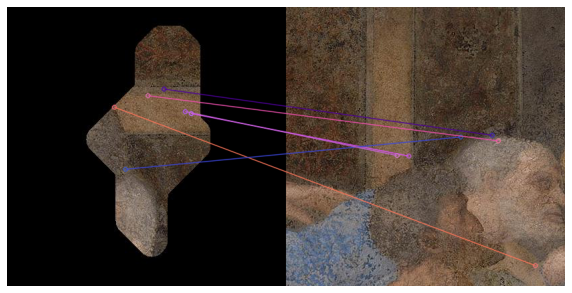

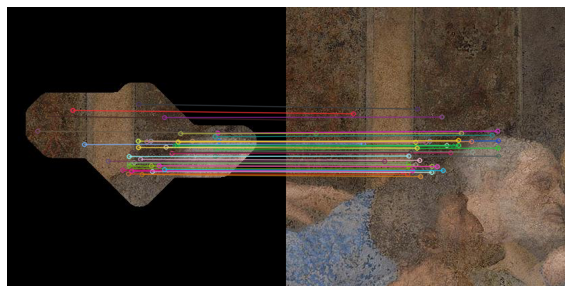

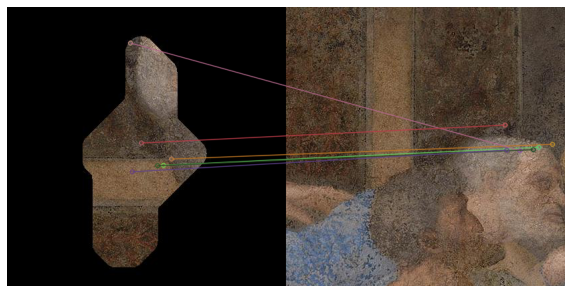

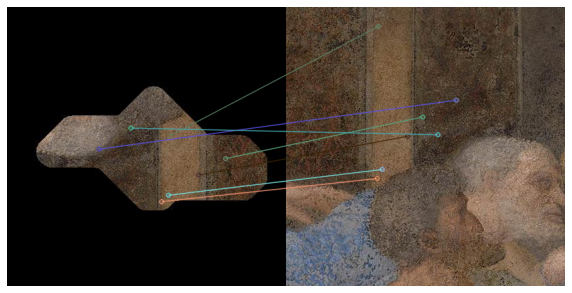

In [259]:
plt.figure(figsize=(10, 10))
plt.imshow(image_r1)
plt.axis('off')
plt.show()

plt.figure(figsize=(10, 10))
plt.imshow(image_r2)
plt.axis('off')
plt.show()

plt.figure(figsize=(10, 10))
plt.imshow(image_r3)
plt.axis('off')
plt.show()

plt.figure(figsize=(10, 10))
plt.imshow(image_r4)
plt.axis('off')
plt.show()

In [ ]:
Number of raw matches: 58.
Number of inliers: 8.
Number of raw matches: 66.
Number of inliers: 28.
Number of raw matches: 62.
Number of inliers: 7.
Number of raw matches: 64.
Number of inliers: 7.
    
[[ 3.38725545e+00 -1.76171897e+00 -2.36918701e+02]
 [ 3.30820961e+00 -1.30368284e+00 -2.48265620e+02]
 [ 8.08677655e-03 -5.79880468e-03  6.43988562e-02]]
Transltation : ( -236.918700669472 , -248.26562009573365 )
Rotation :  -44.3236045199183
[[ 1.16049035e+00  1.84003526e-01 -7.41532848e+01]
 [ 1.35559183e-01  1.27481254e+00 -8.99790278e+01]
 [ 7.09239007e-04  9.05976620e-04  6.46765279e-01]]
Transltation : ( -74.15328477624544 , -89.97902784194915 )
Rotation :  -276.66263933222615
[[ 1.93793852e+00 -3.82734787e+00  7.70177050e+02]
 [ 9.35083120e-01 -1.13261711e+00  2.43070859e+02]
 [ 4.27495240e-03 -1.12498585e-02  2.58636811e+00]]
Transltation : ( 770.1770495046038 , 243.07085864339317 )
Rotation :  -205.75797549055414
[[-8.57626871e+00 -5.24158314e+00  3.39854508e+03]
 [-5.73141149e+00 -1.01597265e+01  3.95302646e+03]
 [-4.01627263e-02 -2.98968713e-02  1.69605554e+01]]
Transltation : ( 3398.5450828703915 , 3953.026460813961 )
Rotation :  56.24569585448475

In [ ]:

# Parameters
max_edge = 1600
max_sum_edges = 2800
model_file = 'models/d2_tf.pth'
multiscale = False
output_extension='.d2-net'
output_type='npz'
preprocessing='caffe'
use_relu=True
image_list_file='fresques/Leonardo-da-Vinci_Ultima-Cena_5193x2926/Leonardo-da-Vinci_Ultima-Cena_5193x2926_2019-2-28_13.56.32/fragments2.txt'
path_images = 'fresques/Leonardo-da-Vinci_Ultima-Cena_5193x2926/Leonardo-da-Vinci_Ultima-Cena_5193x2926_2019-2-28_13.56.32/frag_eroded'
path_keypoints = 'fresques/Leonardo-da-Vinci_Ultima-Cena_5193x2926/Leonardo-da-Vinci_Ultima-Cena_5193x2926_2019-2-28_13.56.32/keypoints/kpts_frag_'
path_imageOriginal = 'fresques/Leonardo-da-Vinci_Ultima-Cena_5193x2926/Leonardo-da-Vinci_Ultima-Cena_5193x2926_2019-2-28_13.56.32/Leonardo-da-Vinci_Ultima-Cena_5193x2926'


# CUDA
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

# Creating CNN model
model = D2Net(
    model_file = model_file,
    use_relu = use_relu,
    use_cuda = use_cuda
)

# Functions
def crop_image(img,xC,yC,sizeX,sizeY):
    y,x,z = img.shape
    startx = xC - sizeX//2
    starty = yC - sizeY//2    
    return img[starty:(starty+sizeY),startx:(startx+sizeX),:]

def filteringBlackAreaKeypoints(img,keypoints):
    new_keypoints = [[1,1,1]]

    for i in keypoints:
        kpt_y = int(i[0])
        kpt_x = int(i[1])
        img_kpt = img[(kpt_y-2):(kpt_y+3),(kpt_x-2):(kpt_x+3),:]
        sum_masque = np.sum(img_kpt)
#         print('sum : ',sum_masque)
        if(sum_masque >  1000):
            new_keypoints = np.concatenate((new_keypoints,[i]),axis=0)
            
    return new_keypoints[1:]

def Detection_keypoints(image,max_edge,max_sum_edges,preprocessing,multiscale):
    
    if len(image.shape) == 2:
        image = image[:, :, np.newaxis]
        image = np.repeat(image, 3, -1)

    # TODO: switch to PIL.Image due to deprecation of scipy.misc.imresize.
    resized_image = image
    if max(resized_image.shape) > max_edge:
        resized_image = scipy.misc.imresize(
            resized_image,
            max_edge / max(resized_image.shape)
        ).astype('float')
    if sum(resized_image.shape[: 2]) > max_sum_edges:
        resized_image = scipy.misc.imresize(
            resized_image,
            max_sum_edges / sum(resized_image.shape[: 2])
        ).astype('float')

    fact_i = image.shape[0] / resized_image.shape[0]
    fact_j = image.shape[1] / resized_image.shape[1]

    input_image = preprocess_image(
        resized_image,
        preprocessing=preprocessing
    )
    
    with torch.no_grad():
        if multiscale:
            keypoints, scores, descriptors = process_multiscale(
                torch.tensor(
                    input_image[np.newaxis, :, :, :].astype(np.float32),
                    device=device
                ),
                model
            )
        else:
            keypoints, scores, descriptors = process_multiscale(
                torch.tensor(
                    input_image[np.newaxis, :, :, :].astype(np.float32),
                    device=device
                ),
                model,
                scales=[1]
            )

    # Input image coordinates
    keypoints[:, 0] *= fact_i
    keypoints[:, 1] *= fact_j
    # i, j -> u, v
    keypoints = keypoints[:, [1, 0, 2]]
    
    keypoints = filteringBlackAreaKeypoints(resized_image,keypoints)
    
    return keypoints, descriptors

#     if args.output_type == 'npz':
#         with open(path + args.output_extension, 'wb') as output_file:
#             np.savez(
#                 output_file,
#                 keypoints=keypoints,
#                 scores=scores,
#                 descriptors=descriptors
#             )
#     elif args.output_type == 'mat':
#         with open(path + args.output_extension, 'wb') as output_file:
#             scipy.io.savemat(
#                 output_file,
#                 {
#                     'keypoints': keypoints,
#                     'scores': scores,
#                     'descriptors': descriptors
#                 }
#             )
#     else:
#         raise ValueError('Unknown output type.')
    

# Process the file
fichier = open(image_list_file, "r")
text = fichier.read()
data = text.split('\n')


for i in range(len(data)-1):
    id_fragment = int(data[i].split(' ')[0])
    Tx = int(data[i].split(' ')[1])
    Ty = int(data[i].split(' ')[2])
    
    path = os.path.join(path_images,'frag_eroded_{}_color.ppm'.format(id_fragment))

    image = imageio.imread(path)
    if len(image.shape) == 2:
        image = image[:, :, np.newaxis]
        image = np.repeat(image, 3, -1)

    # TODO: switch to PIL.Image due to deprecation of scipy.misc.imresize.
    resized_image = image
    if max(resized_image.shape) > max_edge:
        resized_image = scipy.misc.imresize(
            resized_image,
            max_edge / max(resized_image.shape)
        ).astype('float')
    if sum(resized_image.shape[: 2]) > max_sum_edges:
        resized_image = scipy.misc.imresize(
            resized_image,
            max_sum_edges / sum(resized_image.shape[: 2])
        ).astype('float')

    fact_i = image.shape[0] / resized_image.shape[0]
    fact_j = image.shape[1] / resized_image.shape[1]
    
    rotations = np.array([0,90,180,270])
    
    rotations = np.array([0])    
    
    
    for j in rotations:
        
        if j!=0 :
            resized_image = np.rot90(resized_image)
            

        input_image = preprocess_image(
            resized_image,
            preprocessing=preprocessing
        )

        with torch.no_grad():
            if multiscale:
                keypoints, scores, descriptors = process_multiscale(
                    torch.tensor(
                        input_image[np.newaxis, :, :, :].astype(np.float32),
                        device=device
                    ),
                    model
                )
            else:
                keypoints, scores, descriptors = process_multiscale(
                    torch.tensor(
                        input_image[np.newaxis, :, :, :].astype(np.float32),
                        device=device
                    ),
                    model,
                    scales=[1]
                )

        # Input image coordinates
        keypoints[:, 0] *= fact_i
        keypoints[:, 1] *= fact_j
        # i, j -> u, v
        keypoints = keypoints[:, [1, 0, 2]]
        
#         print(keypoints)
#         print(keypoints.shape)        
#         print(type(keypoints))
        keypoints = filteringBlackAreaKeypoints(resized_image,keypoints)
#         print(keypoints)      
#         print(type(keypoints))
        
#         print(descriptors)
#         print(descriptors.shape)
        

        if output_type == 'npz':
            with open(path_keypoints + str(id_fragment) + '_rot_' + str(j) + output_extension, 'wb') as output_file:
                np.savez(
                    output_file,
                    keypoints=keypoints,
                    scores=scores,
                    descriptors=descriptors
                )
        elif output_type == 'mat':
            with open(path + output_extension, 'wb') as output_file:
                scipy.io.savemat(
                    output_file,
                    {
                        'keypoints': keypoints,
                        'scores': scores,
                        'descriptors': descriptors
                    }
                )
        else:
            raise ValueError('Unknown output type.')


In [68]:
print(np.ones(5))

[1. 1. 1. 1. 1.]


<class 'imageio.core.util.Array'>
(3, 411, 411)
<class 'imageio.core.util.Array'>
(411, 411, 3)
<class 'imageio.core.util.Array'>
(411, 411, 3)


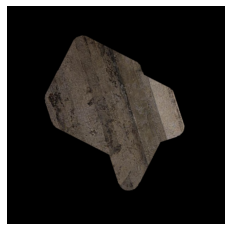

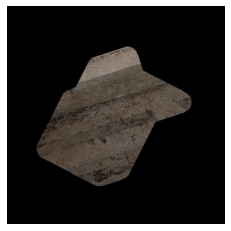

In [14]:
print(type(input_image))
print(input_image.shape)
print(type(resized_image))
print(resized_image.shape)
print(type(np.rot90(resized_image)))
print(np.rot90(resized_image).shape)

plt.figure()
plt.imshow(resized_image)
plt.axis('off')
plt.show()

plt.figure()
plt.imshow(np.rot90(resized_image))
plt.axis('off')
plt.show()

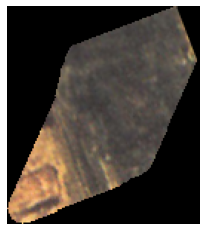

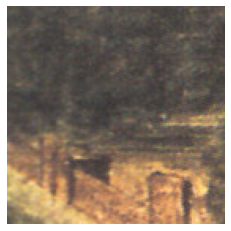

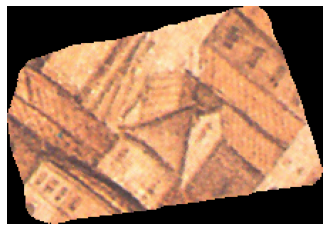

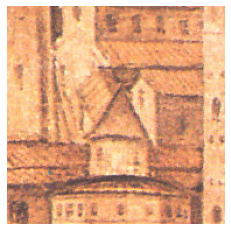

In [57]:
pair_path = os.path.join('6fresques_et','Lanzani_SantAntonioproteggePavia_2440x2524','frag_eroded')
pair_path_fresque = os.path.join('6fresques_et','Lanzani_SantAntonioproteggePavia_2440x2524','Lanzani_SantAntonioproteggePavia_2440x2524.ppm')
pair_path_text = '6fresques_et/Lanzani_SantAntonioproteggePavia_2440x2524/fragments.txt'

nbr_im1 = 117#random.randint(0, 295) # 117
nbr_im2 = 4#random.randint(0, 295) # 4

bool_in_1 = 0
bool_in_2 = 0

image1 = np.array(Image.open(os.path.join(pair_path, 'frag_eroded_{:04d}.ppm'.format(nbr_im1))))
image2 = np.array(Image.open(os.path.join(pair_path, 'frag_eroded_{:04d}.ppm'.format(nbr_im2))))
image3 = np.array(Image.open(pair_path_fresque))

def crop_image(img,xC,yC,sizeX,sizeY):
    y,x,z = img.shape
    startx = xC - sizeX//2
    starty = yC - sizeY//2    
    return img[starty:(starty+sizeY),startx:(startx+sizeX),:]


fichier = open(pair_path_text, "r")
text = fichier.read()
data = text.split('\n')
#print(data)

for i in range(len(data)-1):
    id_fragment = int(data[i].split(' ')[0])
    Tx = int(data[i].split(' ')[1])
    Ty = int(data[i].split(' ')[2])
    #Rot = int(data[nbr_im1].split(' ')[3])
    
    if(nbr_im1 == id_fragment):
        bool_in_1 = 1
        xC1 = Tx
        yC1 = Ty
        sizeX1 = sizeY1 = int(np.mean(image1.shape[0:2]))
        #print(image1.shape[0:2], sizeX1)
        #print(xC1,yC1,sizeX1)
        #print(type(xC1),type(yC1),type(sizeX1))
    elif(nbr_im2 == id_fragment):
        bool_in_2 = 1
        xC2 = Tx
        yC2 = Ty
        sizeX2 = sizeY2 = int(np.mean(image2.shape[0:2]))
        

# im = Image.fromarray(image1)
# im.save("qualitative/images/pair_4/1.jpg")

# im = Image.fromarray(crop_image(image3,xC1,yC1,sizeX1,sizeY1))
# im.save("qualitative/images/pair_4/2.jpg")

# im = Image.fromarray(image2)
# im.save("qualitative/images/pair_5/1.jpg")

# im = Image.fromarray(crop_image(image3,xC2,yC2,sizeX2,sizeY2))
# im.save("qualitative/images/pair_5/2.jpg")

# print(bool_in_1,bool_in_2)

if(bool_in_1 == 1 ):
    plt.figure()
    plt.imshow(image1)
    plt.axis('off')
    plt.show()

    plt.figure()
    plt.imshow(crop_image(image3,xC1,yC1,sizeX1,sizeY1))
    plt.axis('off')
    plt.show()
    
if(bool_in_2 ==1 ):
    plt.figure()
    plt.imshow(image2)
    plt.axis('off')
    plt.show()

    plt.figure()
    plt.imshow(crop_image(image3,xC2,yC2,sizeX2,sizeY2))
    plt.axis('off')
    plt.show()





In [56]:
print(image1[4,4,:])

[0 0 0]


In [ ]:
pair_path = os.path.join('6fresques_et','Leonardo-da-Vinci_Ultima-Cena_5193x2926','frag_eroded')
pair_path_fresque = os.path.join('6fresques_et','Leonardo-da-Vinci_Ultima-Cena_5193x2926','Leonardo-da-Vinci_Ultima-Cena_5193x2926.ppm')
pair_path_text = '6fresques_et/Leonardo-da-Vinci_Ultima-Cena_5193x2926/fragments.txt'

nbr_im1 = 25 #random.randint(0, 295)
nbr_im2 = 4 #random.randint(0, 295)bool_in_1 = 0
bool_in_2 = 0

image1 = np.array(Image.open(os.path.join(pair_path, 'frag_eroded_{:04d}.ppm'.format(nbr_im1))))
image2 = np.array(Image.open(os.path.join(pair_path, 'frag_eroded_{:04d}.ppm'.format(nbr_im2))))
image3 = np.array(Image.open(pair_path_fresque))

def crop_image(img,xC,yC,sizeX,sizeY):
    y,x,z = img.shape
    startx = xC - sizeX//2
    starty = yC - sizeY//2    
    return img[starty:(starty+sizeY),startx:(startx+sizeX),:]


fichier = open(pair_path_text, "r")
text = fichier.read()
data = text.split('\n')
#print(data)

for i in range(len(data)-1):
    id_fragment = int(data[i].split(' ')[0])
    Tx = int(data[i].split(' ')[1])
    Ty = int(data[i].split(' ')[2])
    #Rot = int(data[nbr_im1].split(' ')[3])
    
    if(nbr_im1 == id_fragment):
        bool_in_1 = 1
        xC1 = Tx
        yC1 = Ty
        sizeX1 = sizeY1 = int(max(image1.shape)*1.5)        
    elif(nbr_im2 == id_fragment):
        bool_in_2 = 1
        xC2 = Tx
        yC2 = Ty
        sizeX2 = sizeY2 = int(max(image2.shape)*1.5)

im = Image.fromarray(image1)
im.save("qualitative/images/pair_6/1.jpg")

im = Image.fromarray(crop_image(image3,xC1,yC1,sizeX1,sizeY1))
im.save("qualitative/images/pair_6/2.jpg")

im = Image.fromarray(image2)
im.save("qualitative/images/pair_7/1.jpg")

im = Image.fromarray(crop_image(image3,xC2,yC2,sizeX2,sizeY2))
im.save("qualitative/images/pair_7/2.jpg")

if(bool_in_1 ==1):
    plt.figure()
    plt.imshow(image1)
    plt.axis('off')
    plt.show()

    plt.figure()
    plt.imshow(crop_image(image3,xC1,yC1,sizeX1,sizeY1))
    plt.axis('off')
    plt.show()
    
if(bool_in_2 ==1):
    plt.figure()
    plt.imshow(image2)
    plt.axis('off')
    plt.show()

    plt.figure()
    plt.imshow(crop_image(image3,xC2,yC2,sizeX2,sizeY2))
    plt.axis('off')
    plt.show()


In [ ]:
pair_path = os.path.join('6fresques_et','Michelangelo_ThecreationofAdam_1707x775','frag_eroded')
pair_path_fresque = os.path.join('6fresques_et','Michelangelo_ThecreationofAdam_1707x775','Michelangelo_ThecreationofAdam_1707x775.ppm')
pair_path_text = '6fresques_et/Michelangelo_ThecreationofAdam_1707x775/fragments.txt'

nbr_im1 = 28 #random.randint(0, 295)
nbr_im2 = 4 #random.randint(0, 295)bool_in_1 = 0
bool_in_2 = 0

image1 = np.array(Image.open(os.path.join(pair_path, 'frag_eroded_{:04d}.ppm'.format(nbr_im1))))
image2 = np.array(Image.open(os.path.join(pair_path, 'frag_eroded_{:04d}.ppm'.format(nbr_im2))))
image3 = np.array(Image.open(pair_path_fresque))

def crop_image(img,xC,yC,sizeX,sizeY):
    y,x,z = img.shape
    startx = xC - sizeX//2
    starty = yC - sizeY//2    
    return img[starty:(starty+sizeY),startx:(startx+sizeX),:]


fichier = open(pair_path_text, "r")
text = fichier.read()
data = text.split('\n')
#print(data)

for i in range(len(data)-1):
    id_fragment = int(data[i].split(' ')[0])
    Tx = int(data[i].split(' ')[1])
    Ty = int(data[i].split(' ')[2])
    #Rot = int(data[nbr_im1].split(' ')[3])
    
    if(nbr_im1 == id_fragment):
        bool_in_1 = 1
        xC1 = Tx
        yC1 = Ty
        sizeX1 = sizeY1 = int(max(image1.shape)*1.5)        
    elif(nbr_im2 == id_fragment):
        bool_in_2 = 1
        xC2 = Tx
        yC2 = Ty
        sizeX2 = sizeY2 = int(max(image2.shape)*1.5)

im = Image.fromarray(image1)
im.save("qualitative/images/pair_8/1.jpg")

im = Image.fromarray(crop_image(image3,xC1,yC1,sizeX1,sizeY1))
im.save("qualitative/images/pair_8/2.jpg")

im = Image.fromarray(image2)
im.save("qualitative/images/pair_9/1.jpg")

im = Image.fromarray(crop_image(image3,xC2,yC2,sizeX2,sizeY2))
im.save("qualitative/images/pair_9/2.jpg")

if(bool_in_1 ==1):
    plt.figure()
    plt.imshow(image1)
    plt.axis('off')
    plt.show()

    plt.figure()
    plt.imshow(crop_image(image3,xC1,yC1,sizeX1,sizeY1))
    plt.axis('off')
    plt.show()
    
if(bool_in_2 ==1):
    plt.figure()
    plt.imshow(image2)
    plt.axis('off')
    plt.show()

    plt.figure()
    plt.imshow(crop_image(image3,xC2,yC2,sizeX2,sizeY2))
    plt.axis('off')
    plt.show()


In [ ]:
pair_path = os.path.join('6fresques_et','Perugino_Consegnadellechiavi_2347x1438','frag_eroded')
pair_path_fresque = os.path.join('6fresques_et','Perugino_Consegnadellechiavi_2347x1438','Perugino_Consegnadellechiavi_2347x1438.ppm')
pair_path_text = '6fresques_et/Perugino_Consegnadellechiavi_2347x1438/fragments.txt'

nbr_im1 = 0 #random.randint(0, 295)
nbr_im2 = 1 #random.randint(0, 295)bool_in_1 = 0
bool_in_2 = 0

image1 = np.array(Image.open(os.path.join(pair_path, 'frag_eroded_{:04d}.ppm'.format(nbr_im1))))
image2 = np.array(Image.open(os.path.join(pair_path, 'frag_eroded_{:04d}.ppm'.format(nbr_im2))))
image3 = np.array(Image.open(pair_path_fresque))

def crop_image(img,xC,yC,sizeX,sizeY):
    y,x,z = img.shape
    startx = xC - sizeX//2
    starty = yC - sizeY//2    
    return img[starty:(starty+sizeY),startx:(startx+sizeX),:]


fichier = open(pair_path_text, "r")
text = fichier.read()
data = text.split('\n')
#print(data)

for i in range(len(data)-1):
    id_fragment = int(data[i].split(' ')[0])
    Tx = int(data[i].split(' ')[1])
    Ty = int(data[i].split(' ')[2])
    #Rot = int(data[nbr_im1].split(' ')[3])
    
    if(nbr_im1 == id_fragment):
        bool_in_1 = 1
        xC1 = Tx
        yC1 = Ty
        sizeX1 = sizeY1 = int(max(image1.shape)*1.5)        
    elif(nbr_im2 == id_fragment):
        bool_in_2 = 1
        xC2 = Tx
        yC2 = Ty
        sizeX2 = sizeY2 = int(max(image2.shape)*1.5)

im = Image.fromarray(image1)
im.save("qualitative/images/pair_10/1.jpg")

im = Image.fromarray(crop_image(image3,xC1,yC1,sizeX1,sizeY1))
im.save("qualitative/images/pair_10/2.jpg")

im = Image.fromarray(image2)
im.save("qualitative/images/pair_11/1.jpg")

im = Image.fromarray(crop_image(image3,xC2,yC2,sizeX2,sizeY2))
im.save("qualitative/images/pair_11/2.jpg")

if(bool_in_1 ==1):
    plt.figure()
    plt.imshow(image1)
    plt.axis('off')
    plt.show()

    plt.figure()
    plt.imshow(crop_image(image3,xC1,yC1,sizeX1,sizeY1))
    plt.axis('off')
    plt.show()
    
if(bool_in_2 ==1):
    plt.figure()
    plt.imshow(image2)
    plt.axis('off')
    plt.show()

    plt.figure()
    plt.imshow(crop_image(image3,xC2,yC2,sizeX2,sizeY2))
    plt.axis('off')
    plt.show()


In [ ]:
pair_path = os.path.join('6fresques_et','Piero-della-Francesca_ExaltationoftheCross_1239x900','frag_eroded')
pair_path_fresque = os.path.join('6fresques_et','Piero-della-Francesca_ExaltationoftheCross_1239x900','Piero-della-Francesca_ExaltationoftheCross_1239x900.ppm')
pair_path_text = '6fresques_et/Piero-della-Francesca_ExaltationoftheCross_1239x900/fragments.txt'

nbr_im1 = 126 #random.randint(0, 295)
nbr_im2 = 125bool_in_1 = 0
bool_in_2 = 0

image1 = np.array(Image.open(os.path.join(pair_path, 'frag_eroded_{:04d}.ppm'.format(nbr_im1))))
image2 = np.array(Image.open(os.path.join(pair_path, 'frag_eroded_{:04d}.ppm'.format(nbr_im2))))
image3 = np.array(Image.open(pair_path_fresque))

def crop_image(img,xC,yC,sizeX,sizeY):
    y,x,z = img.shape
    startx = xC - sizeX//2
    starty = yC - sizeY//2    
    return img[starty:(starty+sizeY),startx:(startx+sizeX),:]


fichier = open(pair_path_text, "r")
text = fichier.read()
data = text.split('\n')
#print(data)

for i in range(len(data)-1):
    id_fragment = int(data[i].split(' ')[0])
    Tx = int(data[i].split(' ')[1])
    Ty = int(data[i].split(' ')[2])
    #Rot = int(data[nbr_im1].split(' ')[3])
    
    if(nbr_im1 == id_fragment):
        bool_in_1 = 1
        xC1 = Tx
        yC1 = Ty
        sizeX1 = sizeY1 = int(max(image1.shape)*1.5)        
    elif(nbr_im2 == id_fragment):
        bool_in_2 = 1
        xC2 = Tx
        yC2 = Ty
        sizeX2 = sizeY2 = int(max(image2.shape)*1.5)
        
im = Image.fromarray(image1)
im.save("qualitative/images/pair_12/1.jpg")

im = Image.fromarray(crop_image(image3,xC1,yC1,sizeX1,sizeY1))
im.save("qualitative/images/pair_12/2.jpg")

im = Image.fromarray(image2)
im.save("qualitative/images/pair_13/1.jpg")

im = Image.fromarray(crop_image(image3,xC2,yC2,sizeX2,sizeY2))
im.save("qualitative/images/pair_13/2.jpg")

if(bool_in_1 ==1):
    plt.figure()
    plt.imshow(image1)
    plt.axis('off')
    plt.show()

    plt.figure()
    plt.imshow(crop_image(image3,xC1,yC1,sizeX1,sizeY1))
    plt.axis('off')
    plt.show()
    
if(bool_in_2 ==1):
    plt.figure()
    plt.imshow(image2)
    plt.axis('off')
    plt.show()

    plt.figure()
    plt.imshow(crop_image(image3,xC2,yC2,sizeX2,sizeY2))
    plt.axis('off')
    plt.show()


In [ ]:
pair_path = os.path.join('6fresques_et','Tiepolo_TheInstitutionoftheRosary_850x1231','frag_eroded')
pair_path_fresque = os.path.join('6fresques_et','Tiepolo_TheInstitutionoftheRosary_850x1231','Tiepolo_TheInstitutionoftheRosary_850x1231.ppm')
pair_path_text = '6fresques_et/Tiepolo_TheInstitutionoftheRosary_850x1231/fragments.txt'

nbr_im1 = 17
nbr_im2 = 22bool_in_1 = 0
bool_in_2 = 0

image1 = np.array(Image.open(os.path.join(pair_path, 'frag_eroded_{:04d}.ppm'.format(nbr_im1))))
image2 = np.array(Image.open(os.path.join(pair_path, 'frag_eroded_{:04d}.ppm'.format(nbr_im2))))
image3 = np.array(Image.open(pair_path_fresque))

def crop_image(img,xC,yC,sizeX,sizeY):
    y,x,z = img.shape
    startx = xC - sizeX//2
    starty = yC - sizeY//2    
    return img[starty:(starty+sizeY),startx:(startx+sizeX),:]


fichier = open(pair_path_text, "r")
text = fichier.read()
data = text.split('\n')
#print(data)

for i in range(len(data)-1):
    id_fragment = int(data[i].split(' ')[0])
    Tx = int(data[i].split(' ')[1])
    Ty = int(data[i].split(' ')[2])
    #Rot = int(data[nbr_im1].split(' ')[3])
    
    if(nbr_im1 == id_fragment):
        bool_in_1 = 1
        xC1 = Tx
        yC1 = Ty
        sizeX1 = sizeY1 = int(max(image1.shape)*1.5)        
    elif(nbr_im2 == id_fragment):
        bool_in_2 = 1
        xC2 = Tx
        yC2 = Ty
        sizeX2 = sizeY2 = int(max(image2.shape)*1.5)
        
        
im = Image.fromarray(image1)
im.save("qualitative/images/pair_14/1.jpg")

im = Image.fromarray(crop_image(image3,xC1,yC1,sizeX1,sizeY1))
im.save("qualitative/images/pair_14/2.jpg")

im = Image.fromarray(image2)
im.save("qualitative/images/pair_15/1.jpg")

im = Image.fromarray(crop_image(image3,xC2,yC2,sizeX2,sizeY2))
im.save("qualitative/images/pair_15/2.jpg")

if(bool_in_1 ==1):
    plt.figure()
    plt.imshow(image1)
    plt.axis('off')
    plt.show()

    plt.figure()
    plt.imshow(crop_image(image3,xC1,yC1,sizeX1,sizeY1))
    plt.axis('off')
    plt.show()
    
if(bool_in_2 ==1):
    plt.figure()
    plt.imshow(image2)
    plt.axis('off')
    plt.show()

    plt.figure()
    plt.imshow(crop_image(image3,xC2,yC2,sizeX2,sizeY2))
    plt.axis('off')
    plt.show()
